# Lilium Tower

## Parametrization

In [3]:
import sys; sys.path.append('..')
import MeshFEM, mesh, sparse_matrices, benchmark, field_sampler, mesh_utilities
import inflatables_parametrization as parametrization, numpy as np, importlib, pickle, wall_generation
import utils
import py_newton_optimizer
from py_newton_optimizer import NewtonOptimizerOptions
from numpy.linalg import norm
from io_redirection import suppress_stdout
import visualization, wall_width_formulas as wwf

target_surf = mesh.Mesh('../../examples/lilium.msh')
target_surf.setVertices(utils.prototypeScaleNormalization(target_surf.vertices(), placeAtopFloor=True))
target_surf = mesh_utilities.subdivide_loop(target_surf, 1)

In [4]:
# Choose reasonable stretching bounds in terms of the relative fusing curve widths.
alphaMin = wwf.stretchFactorForCanonicalWallWidth(wwf.canonicalWallWidthForGeometry(2, 10))
alphaMax = wwf.stretchFactorForCanonicalWallWidth(wwf.canonicalWallWidthForGeometry(1, 10))
print(alphaMin, alphaMax)

1.4098490006173308 1.4859772889704024


In [5]:
# Run some iterations of the local-global algorithm to ensure a good separation between singular values.
# This step can also be used as a prediction of the feasiblity of a design surface:
# if it is unable to nearly satisfy the singular value constraints,
# the surface is probably infeasible.
lg = parametrization.LocalGlobalParametrizer(target_surf, parametrization.lscm(target_surf))

lg.alphaMin = 1.4
lg.alphaMax = np.pi / 2
print(lg.energy())
for i in range(1000): lg.runIteration()

print(lg.energy())
lg.runIteration()
print(lg.energy())

79280.02680580925
4.835110230590154
4.833041528173093


In [6]:
rparam = parametrization.RegularizedParametrizerSVD(target_surf, lg.uv())
rparam.alphaMin = alphaMin
rparam.alphaMax = alphaMax

In [7]:
def optimize_rparam(param, alphaRegW, phiRegW, bendRegW):
    param.alphaRegW = alphaRegW
    param.phiRegW = phiRegW
    param.bendRegW = bendRegW
    opts = NewtonOptimizerOptions()
    opts.niter = 2000
    opts.hessianProjectionController = py_newton_optimizer.HessianProjectionAdaptive()
    #opts.hessianProjectionController = py_newton_optimizer.HessianProjectionNever()
    cr = parametrization.regularized_parametrization_newton(param, param.rigidMotionPinVars, opts)

In [8]:
# Rerunning this cell a couple times can improve the results
benchmark.reset()
with suppress_stdout(): optimize_rparam(rparam, 100.0, 10.0, 500.0)
with suppress_stdout(): optimize_rparam(rparam, 10.0, 1.0, 250.0)
with suppress_stdout(): optimize_rparam(rparam, 1.0, 0.1, 125.0)
with suppress_stdout(): optimize_rparam(rparam, 0.1, 0.01, 62.5)
with suppress_stdout(): optimize_rparam(rparam, 0.1, 0.01, 31.25)
benchmark.report()

Newton iterations	508.512	5
    Newton iterate	508.49	717
        Backtracking	7.94289	712
            Update SVD Sensitivities	3.29009	1041
        Compute descent direction	492.363	712
            newton_step	492.359	712
                Newton solve	408.36	1077
                    CHOLMOD Numeric Factorize	397.991	1072
                    Solve	8.58605	713
                        CHOLMOD Backsub	5.69211	712
                        CHOLMOD Numeric Factorize	2.2081	5
                        CHOLMOD Symbolic Factorize	0.623384	5
                hessEval	83.7727	712
                largestMagnitudeEigenvalue	0.13209	10
        Preamble	7.96869	717
            Callback	0.00157595	717
            RegularizedParametrizerSVD gradient	5.48696	717
Update SVD Sensitivities	0.0180688	5
Full time	508.957


In [9]:
# Report the values and gradients of each objective term
print(f'Energies: {utils.allEnergies(rparam)}')
print(f'Gradient Norms: {utils.allGradientNorms(rparam)}')

Energies: {'Full': 39.267456311695916, 'Fitting': 5.472146525712919, 'PhiRegularization': 0.877378089589814, 'AlphaRegularization': 0.6216061801696298, 'BendingRegularization': 32.29632551622356}
Gradient Norms: {'Full': 1.3546261590030618e-09, 'Fitting': 0.10265060240314819, 'PhiRegularization': 0.03278284094833941, 'AlphaRegularization': 0.05810128269356832, 'BendingRegularization': 0.06264848752923059}


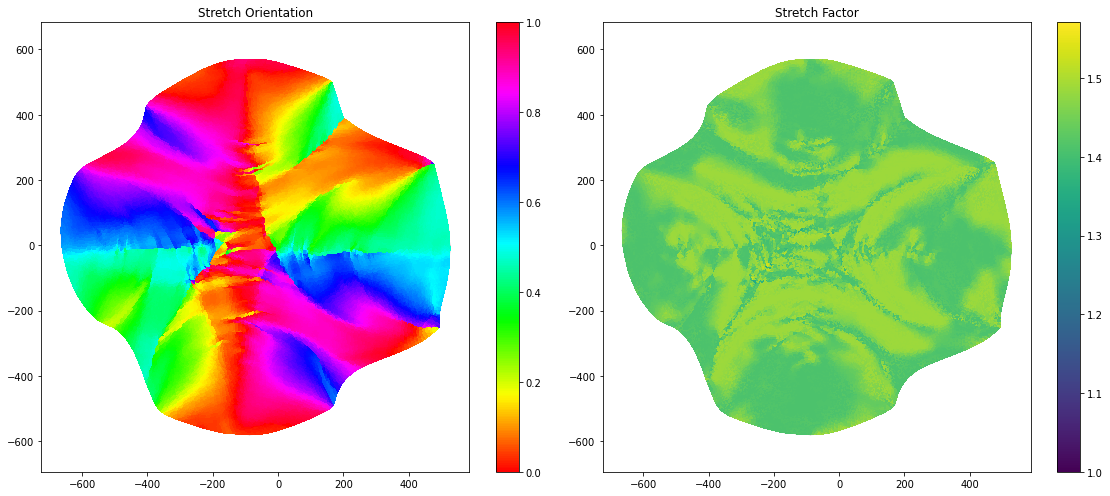

In [10]:
# Visualize the flattening
visualization.visualize(rparam)

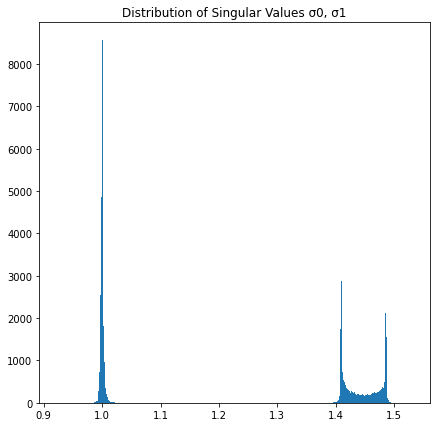

In [11]:
visualization.singularValueHistogram(rparam)

## Upsampling and channel generation

In [12]:
nsubdiv=3
upsampledMesh, upsampledAngles, upsampledStretches = rparam.upsampledVertexLeftStretchAnglesAndMagnitudes(nsubdiv)
upsampledStretches = np.clip(upsampledStretches, alphaMin, alphaMax)
(sdfVertices, sdfTris, sdf) = wall_generation.evaluate_stripe_field(upsampledMesh.vertices(), upsampledMesh.triangles(), upsampledAngles,
                                                                    wwf.canonicalWallWidthForStretchFactor(upsampledStretches), frequency=0.3)

In [13]:
import pickle, mesh, wall_generation, visualization, numpy as np

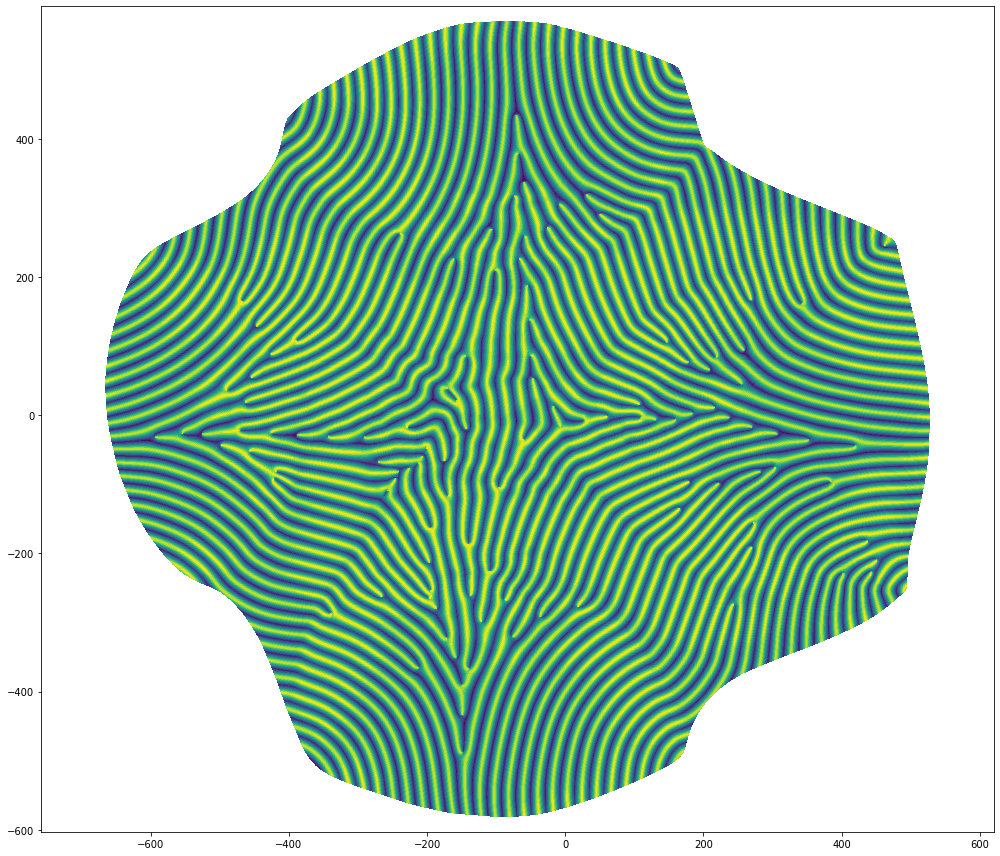

In [14]:
visualization.scalarFieldPlotFast(sdfVertices, sdfTris, sdf, height=12)

In [15]:
pts, edges = wall_generation.extract_contours(sdfVertices, sdfTris, sdf,
                                              targetEdgeSpacing=4.0,
                                              minContourLen=10)

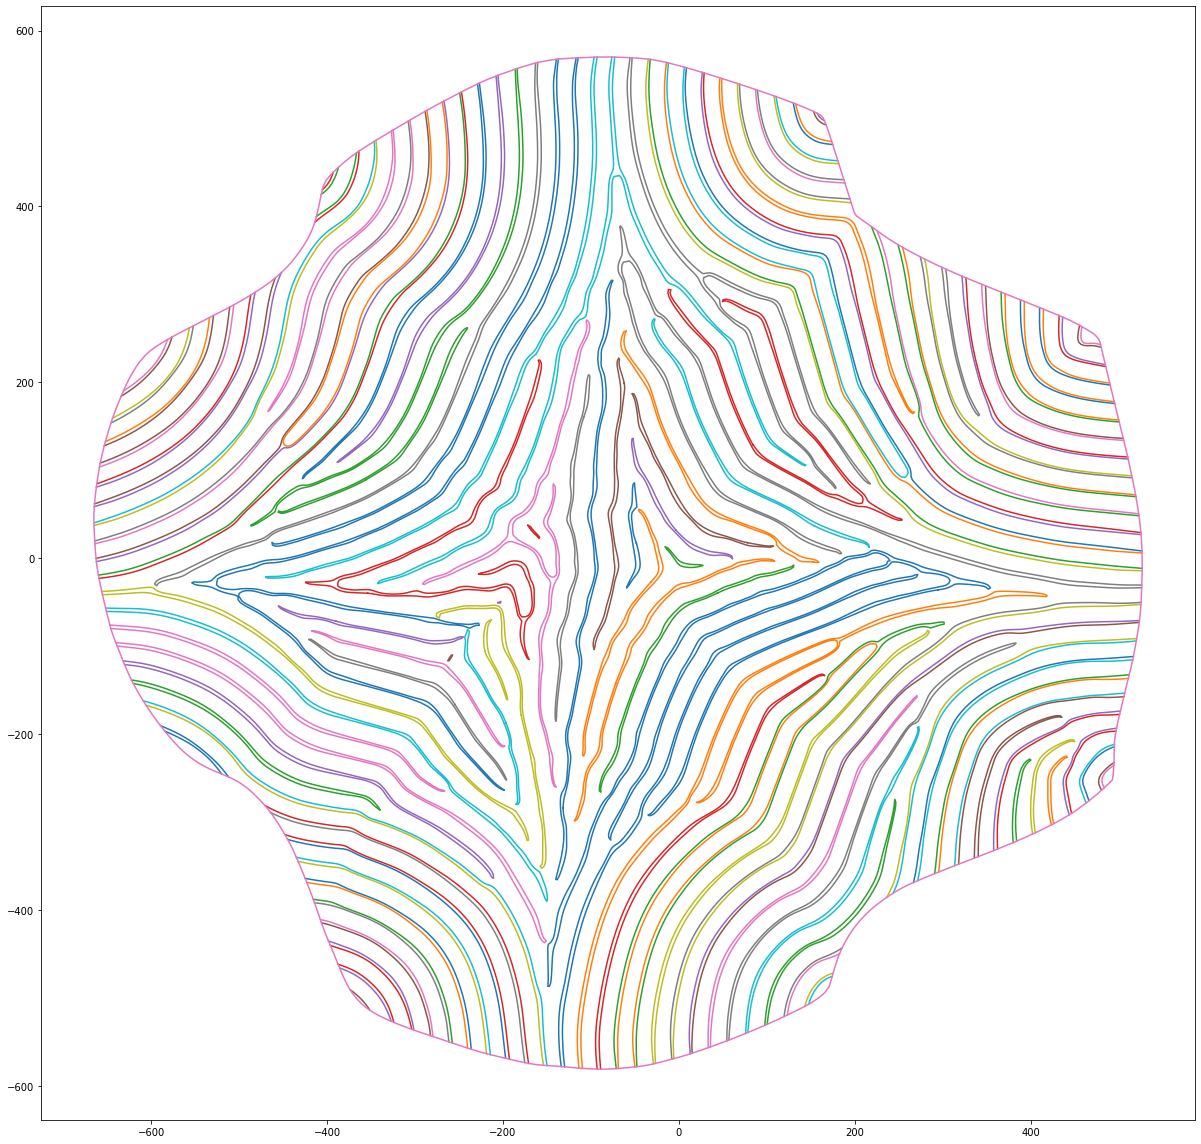

In [16]:
visualization.plot_line_segments(pts, edges, width=20, height=16)

## Meshing and inflation simulation

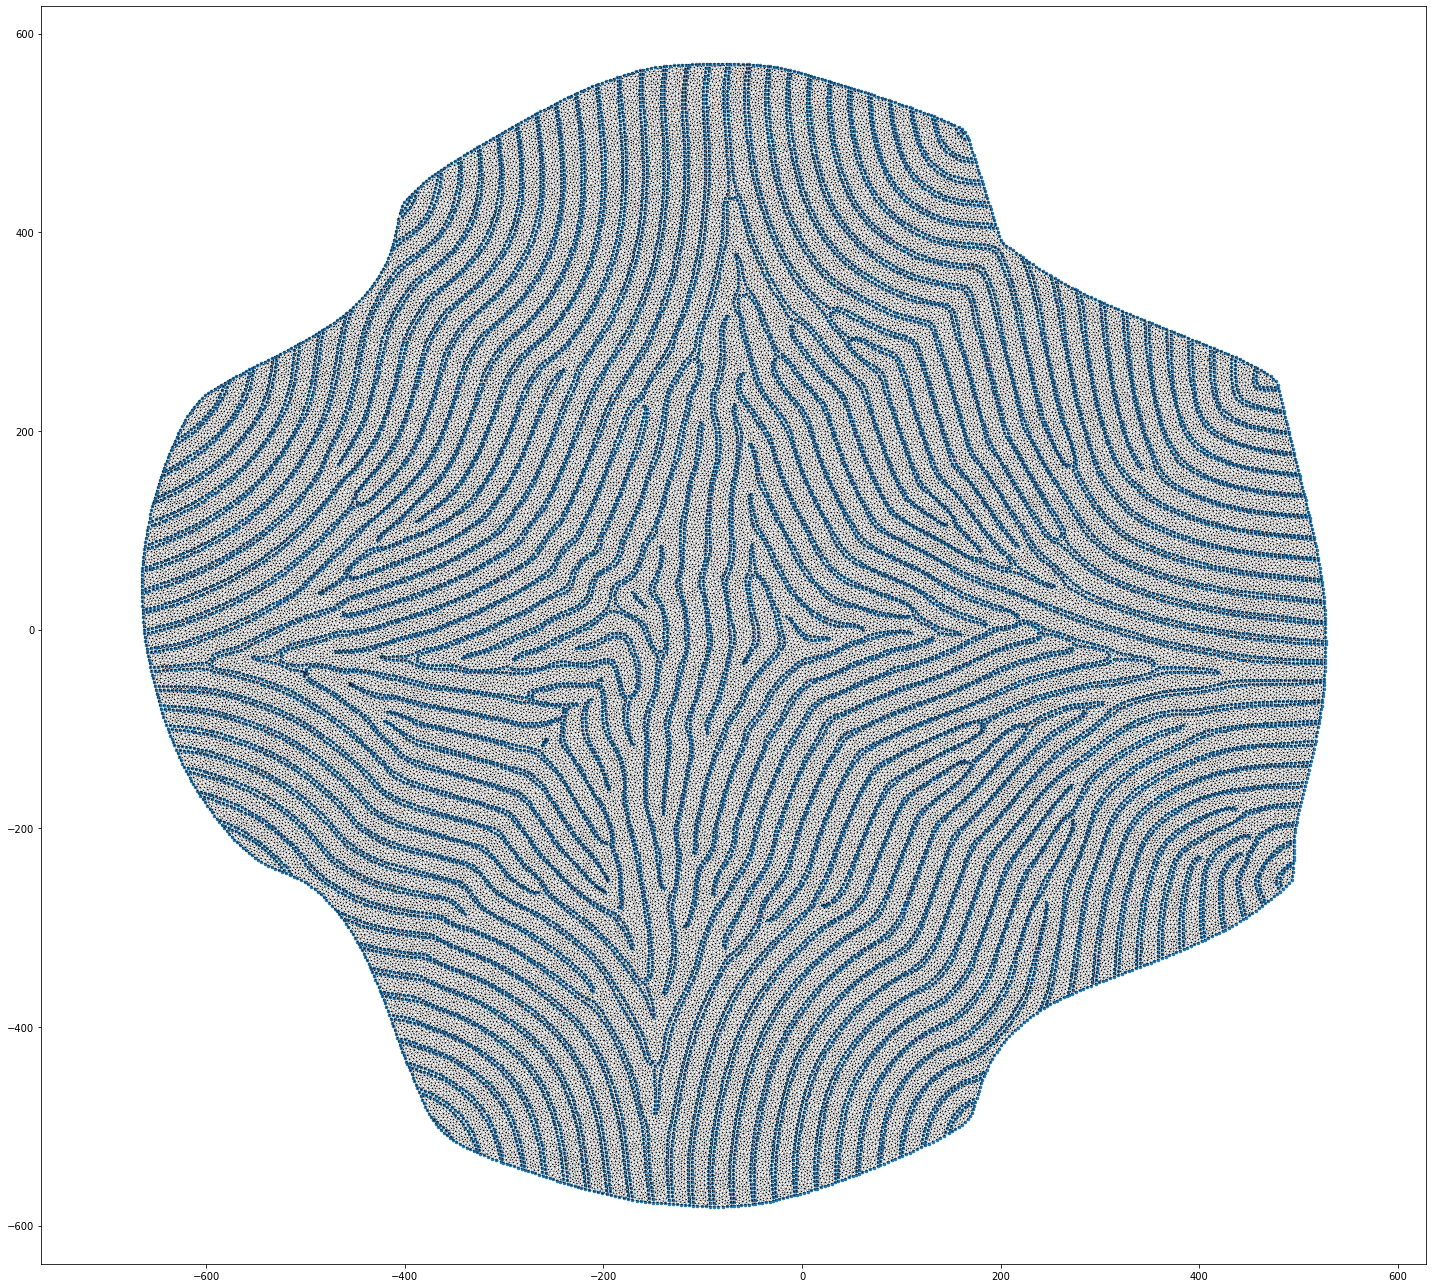

In [17]:
m, fuseMarkers, edgeMarkers = wall_generation.triangulate_channel_walls(pts[:,0:2], edges, triArea=8.0)
visualization.plot_2d_mesh(m, pointList=np.where(np.array(fuseMarkers) == 1)[0], width=20, height=18)

In [18]:
# Optional manual cleanup (e.g., in Blender) when necessary:
# Remove vertices too close to neighboring contours (which cause many tiny triangles in the generated mesh and make the optimizer's job difficult).
# These can be detected by inspecting the wireframe visualization of the triangle mesh created below.
# A common issue is when fusing curves intersect the sheet boundary at a glancing angle; these fusing curves should be simplified to remove their vertices very close to the boundary.
# mesh.save('bad_contour.obj', pts, edges)
# pts, edges = mesh.load_raw('cleaned_contour.obj')

In [19]:
import sheet_meshing, inflation

In [20]:
m, iwv, iwbv = sheet_meshing.newMeshingAlgorithm(sdfVertices, sdfTris, sdf, pts, edges, triArea=8)

In [21]:
isheet = inflation.InflatableSheet(m, iwv)
isheet.setRelaxedStiffnessEpsilon(1e-6)
uv = rparam.uv()

In [22]:
import visualization
v = visualization.getFlatViewer(isheet, 512, 512, False)
v.showWireframe()
v.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [23]:
# Manually stretch the sheet onto the target surface by applying the inverse of the parametrization
paramSampler = field_sampler.FieldSampler(np.pad(uv, [(0, 0), (0, 1)], 'constant'), target_surf.triangles())
liftedSheetPositions = paramSampler.sample(m.vertices(), target_surf.vertices())

isheet.setUninflatedDeformation(liftedSheetPositions.transpose(), prepareRigidMotionPinConstraints=False)

In [24]:
import py_newton_optimizer
niter = 2000
iterations_per_output = 10
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-7
opts.niter = iterations_per_output

In [25]:
from tri_mesh_viewer import TriMeshViewer
viewer = TriMeshViewer(isheet, width=768, height=640, wireframe=True)
viewer.showWireframe()
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [26]:
# Fix the boundary positions
import boundaries
bdryVars = boundaries.getBoundaryVars(isheet)
fixedVars = bdryVars

In [27]:
# Simulate the inflation without any target-attracting forces
import time
isheet.pressure = 0.025
benchmark.reset()
for step in range(int(niter / iterations_per_output)):
    cr = inflation.inflation_newton(isheet, fixedVars, opts)
    if cr.numIters() < iterations_per_output: break
    viewer.update()
    time.sleep(0.05) # Allow some mesh synchronization time for pythreejs
benchmark.report()

InflatableSheet setVars	0.246876	7
Newton iterations	670.321	7
    InflatableSheet energy	0.0621901	7
    InflatableSheet gradient	0.120492	6
    Newton iterate	670.123	63
        Backtracking	3.59042	62
            InflatableSheet energy	0.782701	98
            InflatableSheet setVars	2.75292	98
        Compute descent direction	664.376	62
            newton_step	664.375	62
                Newton solve	642.171	82
                    CHOLMOD Numeric Factorize	569.342	75
                    Solve	70.809	64
                        CHOLMOD Backsub	7.64994	62
                        CHOLMOD Numeric Factorize	49.5985	7
                        CHOLMOD Symbolic Factorize	13.4573	7
                hessEval	19.0898	62
                largestMagnitudeEigenvalue	3.00313	7
        Preamble	2.08345	63
            Callback	6.1512e-05	63
            InflatableSheet energy	0.589978	63
            InflatableSheet gradient	1.32011	63
Full time	678.878


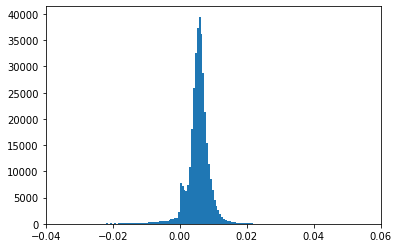

In [28]:
# Plot maximum tensile strains in the sheet to verify the pressure is reasonable
from matplotlib import pyplot as plt
plt.hist(utils.getStrains(isheet)[:, 0], bins=1000);
plt.xlim(-0.04, 0.06);

## Shape Optimization

In [29]:
# Reset the inflation and set up target-attraction forces
isheet.setUninflatedDeformation(liftedSheetPositions.transpose(), prepareRigidMotionPinConstraints=False)
targetAttractedSheet = inflation.TargetAttractedInflation(isheet, target_surf)
targetAttractedSheet.energy(targetAttractedSheet.EnergyType.Fitting)

7.984511307257294e-29

In [30]:
targetAttractedSheet.targetSurfaceFitter().holdClosestPointsFixed = True
targetAttractedSheet.fittingWeight = 1e-5

In [31]:
# Re-inflate, this time applying target-attraction forces.
import time
isheet.pressure = 0.025
benchmark.reset()
for step in range(int(niter / iterations_per_output)):
    cr = inflation.inflation_newton(targetAttractedSheet, fixedVars, opts)
    if cr.numIters() < iterations_per_output: break
    viewer.update()
    time.sleep(0.05) # Allow some mesh synchronization time for pythreejs
benchmark.report()

InflatableSheet setVars	0.217554	7
Newton iterations	643.659	7
    InflatableSheet energy	0.0637305	7
    InflatableSheet gradient	0.12295	6
    Newton iterate	643.45	63
        Backtracking	3.54914	62
            InflatableSheet energy	0.776533	100
            InflatableSheet setVars	2.64295	100
        Compute descent direction	637.77	62
            newton_step	637.769	62
                Newton solve	615.56	81
                    CHOLMOD Numeric Factorize	540.33	74
                    Solve	73.3993	63
                        CHOLMOD Backsub	7.55853	62
                        CHOLMOD Numeric Factorize	52.5801	7
                        CHOLMOD Symbolic Factorize	13.161	7
                hessEval	20.0324	62
                largestMagnitudeEigenvalue	2.08826	6
        Preamble	2.06306	63
            Callback	5.45979e-05	63
            InflatableSheet energy	0.579082	63
            InflatableSheet gradient	1.22322	63
Full time	651.871


In [ ]:
# Set up the sheet optimizer
import sheet_optimizer, opt_config
origDesignMesh = isheet.mesh().copy()

sheet_opt = sheet_optimizer.PySheetOptimizer(targetAttractedSheet, fixedVars, renderMode=sheet_optimizer.RenderMode.PYTHREEJS,
                                             detActivationThreshold=0.9, detActivationThresholdTubeTri=0.5,
                                             originalDesignMesh=origDesignMesh, fusingCurveSmoothnessConfig=opt_config.FusingCurveSmoothnessParams(0.0, 0.0, 1.0, 1.0))

In [ ]:
# Configure some more weights
sheet_opt.rso.compressionPenaltyWeight = 1e-6
fcs = sheet_opt.rso.fusingCurveSmoothness()
fcs.interiorWeight = 0.05

In [ ]:
sheet_opt.flat_viewer.showWireframe()
sheet_opt.viewer()

In [ ]:
# Run the optimization
sheet_opt.setSolver(sheet_optimizer.Solver.SCIPY)
sheet_opt.optimize()

In [ ]:
# Lower the interior weight
fcs = sheet_opt.rso.fusingCurveSmoothness()
fcs.interiorWeight = 0.05

In [ ]:
# Continue the optimization
sheet_opt.optimize()

In [ ]:
utils.allGradientNorms(sheet_opt.rso)

In [ ]:
utils.allEnergies(sheet_opt.rso)

In [ ]:
# Remove the target-attraction force and recompute the equilibrium
targetAttractedSheet.fittingWeight = 1e-8
inflation.inflation_newton(targetAttractedSheet, sheet_opt.rso.fixedEquilibriumVars(), sheet_opt.opts)
viewer.update()

In [ ]:
# Save the full state for later reloading with `sheet_optimizer.load()`
sheet_opt.save('sheet_opt.pkl.gz')

### Generate Fabrication Files

In [ ]:
scaleFactor = 1.15 # Factor for fine-tuning size to fit the machine's build area
channelMargin = 8 / scaleFactor # 8mm channel margin
tabMargin = 2 / scaleFactor # 2mm tab margin

In [ ]:
isheet = sheet_opt.rso.sheet()
optMesh = sheet_opt.rso.mesh().copy()
origMesh = sheet_opt.rso.originalMesh().copy()
import inflation
tas = sheet_opt.rso.targetAttractedInflation()
tsf = tas.targetSurfaceFitter()
targetSurf = mesh.Mesh(tsf.targetSurfaceV, tsf.targetSurfaceF)
iwv = [isheet.isWallVtx(i) for i in range(isheet.mesh().numVertices())]

In [ ]:
import fabrication
fabrication.writeFabricationData('fabrication_data/Lilium/fixed_bdry', origMesh, optMesh, iwv, targetSurf, uv,
                                 scale=scaleFactor, numTabs=80, inletOffset=0.742, tabOffset=0.60 / 80,
                                 channelMargin=channelMargin, tabMargin=tabMargin, tabWidth=5, tabHeight=8, fuseSeamWidth=1.0, inletScale=12 / channelMargin / scaleFactor,
                                 overlap=0.0, smartOuterChannel=True)